# Run this to import required libraries

In [3]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

# Currently using a training library of different imaging systems but looking to impliment out images... need to build a training library

In [4]:
# Define dataset path (adjust path if needed)
data_dir = "/Users/gracecawley/Desktop/Research/CNN/plankton_data/sioc_209_15k"

# Set Image Size and Batch Size
image_size = (128, 128) #every image is squashed or stretched to 128x128 pixels 
batch_size = 32 #computer looks at 32 images at a time while learning
val_split = 0.3  #30% of the pictures check the model’s work, the other 70% is used for learning

# Load Train Dataset
train_ds = keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=val_split,
    subset="training",
    seed=42,
    image_size=image_size,
    batch_size=batch_size,
    label_mode="categorical"
)

# Load Validation Dataset
val_ds = keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=val_split,
    subset="validation",
    seed=42,
    image_size=image_size,
    batch_size=batch_size,
    label_mode="categorical"
)

# Split validation set into validation and test
val_batches = tf.data.experimental.cardinality(val_ds)
test_size = max(10, val_batches.numpy() // 3)  # Ensure at least 10 test batches
test_ds = val_ds.take(test_size)
val_ds = val_ds.skip(test_size)

print(f"✅ Training Batches: {tf.data.experimental.cardinality(train_ds).numpy()}")
print(f"✅ Validation Batches: {tf.data.experimental.cardinality(val_ds).numpy()}")
print(f"✅ Test Batches: {tf.data.experimental.cardinality(test_ds).numpy()}")


Found 15000 files belonging to 30 classes.
Using 10500 files for training.
Found 15000 files belonging to 30 classes.
Using 4500 files for validation.
✅ Training Batches: 329
✅ Validation Batches: 94
✅ Test Batches: 47


# Normalize Data
    Ensures images are scaled between 0 and 1

train_ds is our training dataset, with each item being a tuple: (image, label).

map(...) applies the function to every (image, label) in the dataset.

lambda x, y: (...) is a small, anonymous function that takes x (the image) and y (the label).

tf.cast(x, tf.float32): converts the pixel values into float32. This is required to do math like division.

x / 255.0: rescales the pixel values to the range [0.0, 1.0], which is a common preprocessing step in image-based deep learning.

In [5]:
# normalizing the images
train_ds_norm = train_ds.map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, y))
val_ds_norm = val_ds.map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, y))
test_ds_norm = test_ds.map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, y))

#prefetching the images (so computer doesn't get bored)
train_ds_norm = train_ds_norm.prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds_norm = val_ds_norm.prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds_norm = test_ds_norm.prefetch(buffer_size=tf.data.AUTOTUNE)


# CNN Model Architecture

Conv2D(16, 3, ...): 16 filters, 3x3 kernel size, "same" padding means output size stays the same.

ReLU: introduces non-linearity, so the model can learn complex patterns.

MaxPooling2D(2): downscales the feature map by taking the max value over 2x2 windows — helps reduce spatial size and overfitting.

Repeat the same pattern 3 times, increasing the filter sizes. earlier layers detect basic edges and textures, while later layers can help in detecting more complex shapes and object parts! (Helpfulf or zooplankton :))
for size in [32, 64, 64]:
        x = layers.Conv2D(size, 3, padding="same", activation="relu")(x)
        x = layers.MaxPooling2D(2, padding="same")(x)

Flatten(): Converts the 2D feature maps into a 1D vector, so you can feed it into Dense layers.

Two Dense(512, relu) layers: classic fully connected layers to learn high-level abstract representations.

Kinda like the final reasoning before classification! (Maybe a good place to optimize)



In [6]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape) #defines shape of input imgae

    x = layers.Conv2D(16, 3, padding="same", activation="relu")(inputs)
    x = layers.MaxPooling2D(2, padding="same")(x)

    for size in [32, 64, 64]:
        x = layers.Conv2D(size, 3, padding="same", activation="relu")(x)
        x = layers.MaxPooling2D(2, padding="same")(x)

    x = layers.Flatten()(x)
    x = layers.Dense(512, activation="relu")(x)
    x = layers.Dense(512, activation="relu")(x)

    # Output Layer
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    return keras.Model(inputs, outputs)

# Create the model
input_shape = image_size + (3,)  # 3 for RGB images
num_classes = len(train_ds.class_names)
model = make_model(input_shape, num_classes)

# Display model architecture
#keras.utils.plot_model(model, show_shapes=True) #generates visual flowchart of CNN


📸 INPUT
InputLayer
Shape: (None, 128, 128, 3)
This means you're feeding in RGB images that are 128×128 pixels.
The None means batch size is flexible (you can pass 1, 32, 64, etc. images at once).

🧱 CONVOLUTIONAL + POOLING BLOCKS
These are the feature extractor layers — they transform your raw image into abstract, high-level patterns the model can understand.

🌀 Conv2D (16 filters)
Input shape: (128, 128, 3)
Output shape: (128, 128, 16)
Applies 16 filters to the image. Each filter “learns” to detect a specific feature — like edges, textures, or patterns.

🔽 MaxPooling2D
Output shape: (64, 64, 16)
Reduces spatial resolution by 2× (halves width & height).
Keeps the most important features while making processing more efficient.
Then the same Conv + Pooling cycle happens three more times, with deeper and more numerous filters:
🌀 Conv2D (32 filters) → 🔽 MaxPooling → (32, 32, 32)
🌀 Conv2D (64 filters) → 🔽 MaxPooling → (16, 16, 64)
🌀 Conv2D (64 filters) → 🔽 MaxPooling → (8, 8, 64)

At this point:
You've compressed the 128×128 image down to an 8×8 grid.
Each cell in this grid has 64 feature channels (abstract pattern maps).
This is your deep feature map.

🔁 Flatten
Takes the (8, 8, 64) tensor and reshapes it into a 1D vector of size 4096.
This is the input to your Dense (fully connected) layers.

🧠 Dense (512) → Dense (512)
These are traditional neural network layers.
They combine features learned by the Conv2D stack to form a final decision.
512 units means each layer has 512 neurons.

🎯 Dense (30) — Final Output
Outputs a vector of length 30 — one value per class.
After softmax (implied), this becomes a probability distribution over your 30 classes.
Example: [0.01, 0.87, 0.03, ..., 0.02] → predicted class is #2.

# Train Model

In [7]:
# Number of times the model will see the entire training dataset
# More epochs = more learning, but also more risk of overfitting or long runtimes
epochs = 10

# ---------------------------------------------------------
# Callbacks are tools that let us do things during training,
# like saving models, stopping early, or adjusting learning rate.
# ---------------------------------------------------------

# This callback saves the model at the end of each epoch (e.g., after 1st, 2nd, ..., 10th)
# It saves the full model (architecture + weights)
# Optional: add save_best_only=True to only save the best model (based on validation loss)
callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]

# ---------------------------------------------------------
# Now we compile the model: define how it learns and how we track performance
# ---------------------------------------------------------

model.compile(
    # Adam is a commonly used optimizer — it adjusts weights during training
    # 3e-4 is the learning rate (how big each update step is)
    optimizer=keras.optimizers.Adam(3e-4),

    # CategoricalCrossentropy is the right loss function for multi-class classification
    # from_logits=False means the model already uses a softmax in the last layer
    loss=keras.losses.CategoricalCrossentropy(from_logits=False),

    # We'll track "accuracy" during training and validation to monitor performance
    metrics=["accuracy"],
)

# ---------------------------------------------------------
# Train the model using the training dataset
# It will also evaluate performance on the validation dataset after each epoch
# ---------------------------------------------------------

history = model.fit(
    train_ds_norm,          # Normalized training images and labels
    epochs=epochs,          # How many times to go through the training data
    validation_data=val_ds_norm,  # Validation set to check performance after each epoch
    callbacks=callbacks,    # Save models during training
)

# ---------------------------------------------------------
# Save the final version of the trained model to a file
# This lets you reload it later to make predictions or keep training
# ---------------------------------------------------------

model.save("plankton_cnn_model.keras")


Epoch 1/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 26s 77ms/step - accuracy: 0.1207 - loss: 3.0828 - val_accuracy: 0.3097 - val_loss: 2.3307
Epoch 2/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 25s 76ms/step - accuracy: 0.3375 - loss: 2.1994 - val_accuracy: 0.4002 - val_loss: 1.9497
Epoch 3/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 25s 76ms/step - accuracy: 0.4544 - loss: 1.7705 - val_accuracy: 0.4836 - val_loss: 1.6834
Epoch 4/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 25s 77ms/step - accuracy: 0.5346 - loss: 1.5048 - val_accuracy: 0.5264 - val_loss: 1.5500
Epoch 5/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 25s 76ms/step - accuracy: 0.5900 - loss: 1.3139 - val_accuracy: 0.5421 - val_loss: 1.5242
Epoch 6/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 26s 79ms/step - accuracy: 0.6543 - loss: 1.1027 - val_accuracy: 0.5487 - val_loss: 1.5343
Epoch 7/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 26s 79ms/step - accuracy: 0.7022 - loss: 0.9277 - val_accuracy: 0.5674 - val_loss: 1.5891
Epoch 8/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 26s 80ms/step - accuracy: 0.7430 - loss: 0.7914 - 

# Evaluate Model

In [8]:
# ---------------------------------------------------------
# Evaluate the trained model on a separate test dataset
# This helps us understand how well the model generalizes
# to completely new (unseen) data
# ---------------------------------------------------------
print("\n🔍 Evaluating model on test dataset...")
model.evaluate(test_ds_norm)  # Returns test loss and accuracy

# ---------------------------------------------------------
# Use the trained model to make predictions on test images
# 'predict' returns a probability distribution over all classes for each image
# ---------------------------------------------------------
pred = model.predict(test_ds_norm)

# ---------------------------------------------------------
# Convert predicted probabilities into actual class predictions
# np.argmax() finds the index of the highest probability for each prediction,
# which corresponds to the most likely class label
# ---------------------------------------------------------
pred_classes = np.argmax(pred, axis=1)


🔍 Evaluating model on test dataset...
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.5506 - loss: 1.9239
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step


# Training and Validation Curve

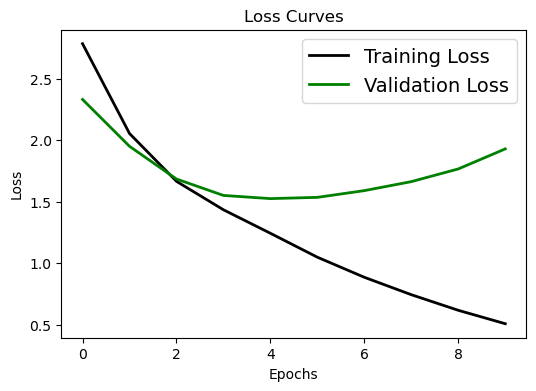

In [9]:
#Loss Curve
plt.figure(figsize=[6,4])
plt.plot(history.history['loss'], 'black', linewidth=2.0)
plt.plot(history.history['val_loss'], 'green', linewidth=2.0)
plt.legend(['Training Loss', 'Validation Loss'], fontsize=14)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.title('Loss Curves', fontsize=12)
plt.show()


This plot shows how the model's error changes over each training epoch for both the training data and validation data. Ideally, both curves should decrease and level off, indicating the model is learning useful patterns and generalizing well to unseen data.

If the validation loss starts increasing while training loss continues to decrease, this suggests overfitting — the model is learning the training data too well and not generalizing.

If both losses remain high, the model may be underfitting, it's too simple, or it’s not training long enough.

If the curves are noisy or unstable, the learning rate might be too high, or the model may need more data or regularization.

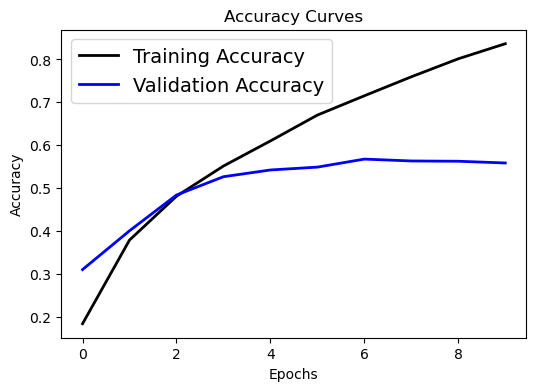

In [10]:
#Accuracy Curve
plt.figure(figsize=[6,4])
plt.plot(history.history['accuracy'], 'black', linewidth=2.0)
plt.plot(history.history['val_accuracy'], 'blue', linewidth=2.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'], fontsize=14)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Accuracy', fontsize=10)
plt.title('Accuracy Curves', fontsize=12)
plt.show()


This plot shows how the model’s prediction accuracy changes over training epochs for both the training set (black) and the validation set (blue). Accuracy reflects the percentage of images the model classified correctly.

If both training and validation accuracy increase and level off, it indicates the model is learning and generalizing well.

If training accuracy is high but validation accuracy stays low or decreases, the model is likely overfitting, it’s memorizing the training data but failing to perform well on unseen data.

If both accuracies remain low, the model may be underfitting, it’s not complex enough to capture the patterns in the data, or it may need more training time.

If the curves are noisy or unstable, the learning rate may be too high, or there could be inconsistencies in the data.

# Confusion Matrix

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━

2025-07-01 11:12:00.133846: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


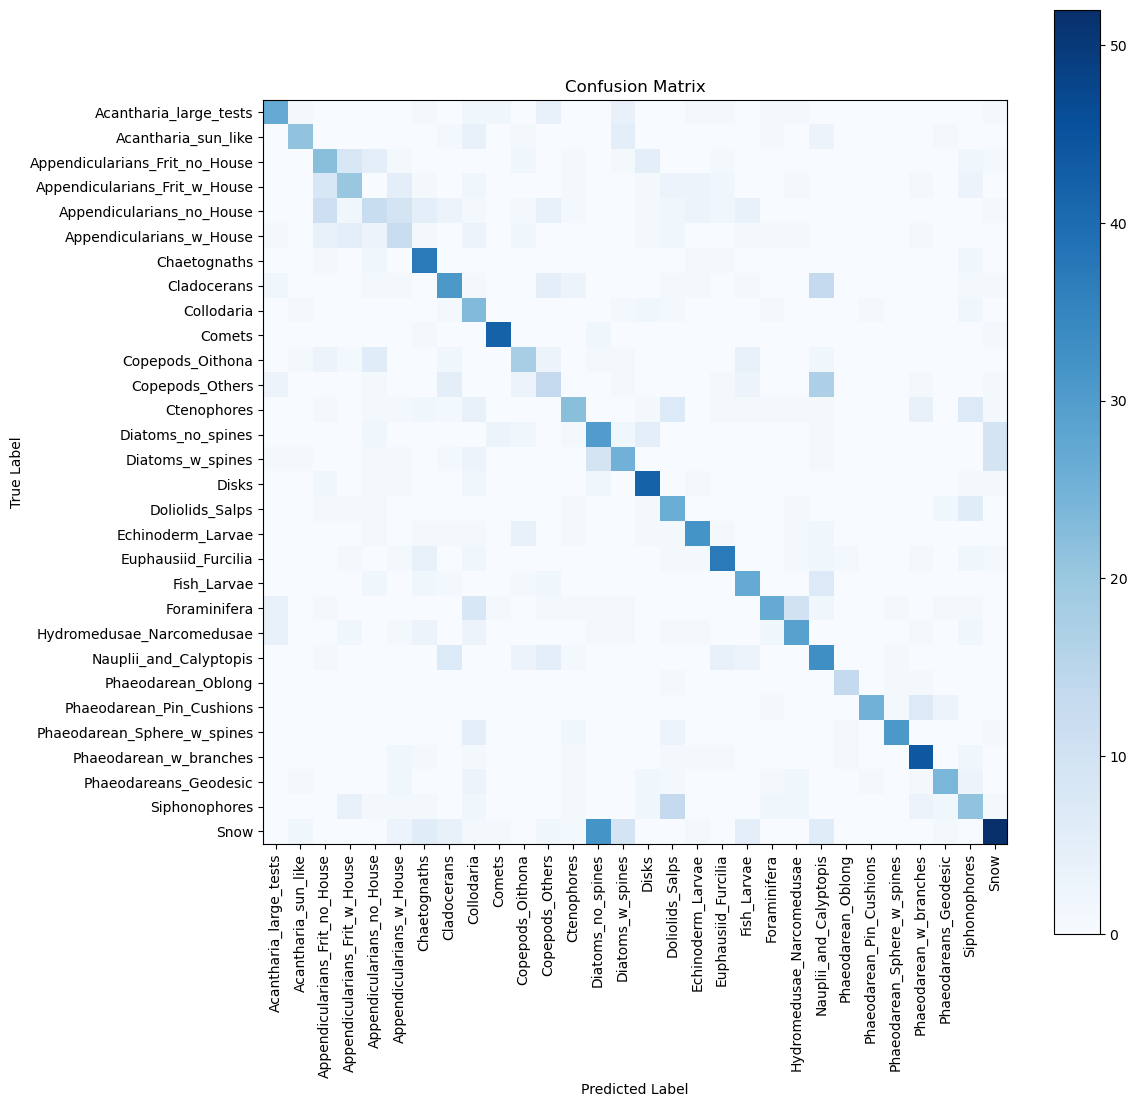

In [11]:
# ---------------------------------------------------------
# Create a confusion matrix to evaluate model performance
# This shows how often the model predicts each class correctly (or not)
# ---------------------------------------------------------
num_classes = len(train_ds.class_names) #number of classes from training model
conf_matrix = np.zeros((num_classes, num_classes), dtype=np.int32)

# Iterate through test dataset
for (x_batch, y_batch) in test_ds_norm:
    preds = model.predict(x_batch)
    pred_classes = np.argmax(preds, axis=1)
    true_classes = np.argmax(y_batch.numpy(), axis=1)

    for t, p in zip(true_classes, pred_classes):
        conf_matrix[t, p] += 1  # Increment count

#Plots the confusion matrix as a heatmap
plt.figure(figsize=(12, 12))
plt.imshow(conf_matrix, cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.colorbar()
plt.xticks(np.arange(num_classes), train_ds.class_names, rotation=90)
plt.yticks(np.arange(num_classes), train_ds.class_names)
plt.show()
